<a href="https://colab.research.google.com/github/KwanJeong/lung_segmentation/blob/main/lung_segmentation_with_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/KwanJeong/lung_segmentation.git

fatal: destination path 'lung_segmentation' already exists and is not an empty directory.


In [2]:
import tensorflow as tf
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPool2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.layers import BatchNormalization, concatenate
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2

# Hyper parameters

In [3]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 50
BATCH_SIZE = 16
INIT_FILTERS = 32
ACTIVATION_FN = "elu"
SEED = 42 # By using the same random seed, the images and masks will still correlate.

# Load Data

In [4]:
BASE_PATH = './lung_segmentation'
IMG_DIR = os.path.join(BASE_PATH, "Data", "2d_images")
MASK_DIR = os.path.join(BASE_PATH, "Data", "2d_masks")
img_path = sorted(glob.glob(os.path.join(IMG_DIR, '*.tif')))
mask_path = sorted(glob.glob(os.path.join(MASK_DIR, '*.tif')))

# Load imgs and masks

In [5]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return cv2.resize(img, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

def load_mask(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.
    return cv2.resize(img, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

In [6]:
imgs = np.stack([load_img(i_path) for i_path in img_path])
masks = np.stack([load_mask(m_path) for m_path in mask_path])

# Check images and the corresponding masks

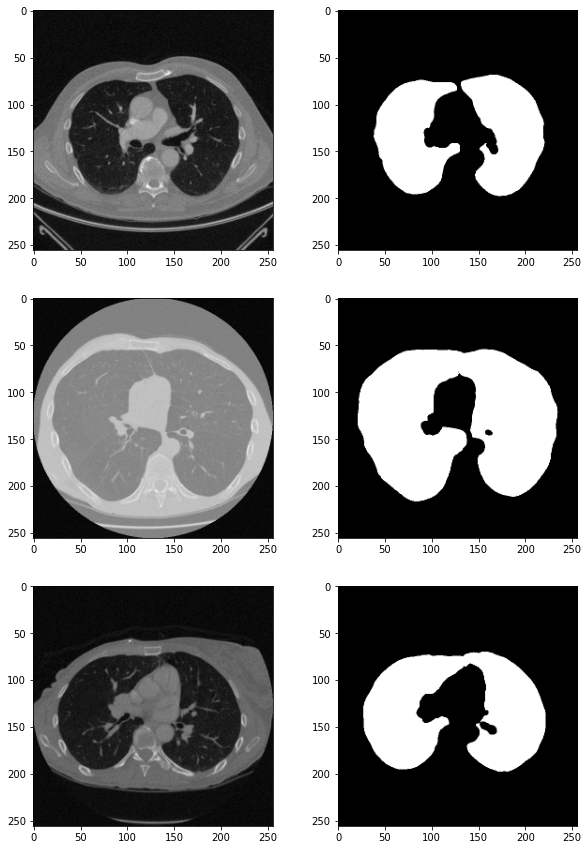

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    ax[i,0].imshow(imgs[i], cmap='gray')
    ax[i,1].imshow(masks[i], cmap='gray')
plt.show()

# Transform image shapes into shapes that can be put in the model
- By using the same random seed, the images and masks will still correlate

In [8]:
imgs = imgs[:,:,:,np.newaxis]
masks = masks[:,:,:,np.newaxis]

t_imgs = imgs[:230]
t_masks = masks[:230]
v_imgs = imgs[-37:]
v_masks = masks[-37:]

print(t_imgs.shape)
print(t_masks.shape)
print(v_imgs.shape)
print(v_masks.shape)

(230, 256, 256, 1)
(230, 256, 256, 1)
(37, 256, 256, 1)
(37, 256, 256, 1)


# Expands image set by giving the images random rotation and shift

In [9]:
def image_augmentation_generator(train, val):
    data_generator = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.1,
            height_shift_range=0.1).flow(train, train, BATCH_SIZE, seed=SEED)
    mask_generator = ImageDataGenerator(
           rotation_range=45,
           width_shift_range=0.1,
           height_shift_range=0.1).flow(val, val, BATCH_SIZE, seed=SEED)
    while True:
        batch_t, _ = data_generator.next()
        batch_v, _ = mask_generator.next()
        yield batch_t, batch_v

# Create an U-net for Lung Segmentation

In [10]:
def conv_layer(layer, filters, activation, kernel_size=(3, 3)):
    layer = Conv2D(filters=filters, kernel_size=kernel_size, activation=None, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation(activation)(layer)
    return layer

In [11]:
input_layer = Input(shape=t_imgs.shape[1:])

filters = INIT_FILTERS
c1 = conv_layer(layer=input_layer, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c1)

filters *= 2
c2 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c2)

filters *= 2
c3 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c3)

filters *= 2
c4 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(c4), c3], axis=-1)

l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(l), c2], axis=-1)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(l), c1], axis=-1)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)

output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(l)
    
model = Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Setting AI Model Options

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc','mse'])

# Training U-net

In [13]:
history = model.fit(image_augmentation_generator(t_imgs, t_masks),
                    epochs=EPOCHS,
                    steps_per_epoch = 60,
                    validation_data = (v_imgs, v_masks),
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, varbose=1,
                                                 mode='auto', min_lr=1e-5)
                    ])

Epoch 1/50
60/60 [==============================] - 51s 614ms/step - loss: 0.2370 - acc: 0.9067 - mse: 0.0611 - val_loss: 1.5209 - val_acc: 0.6956 - val_mse: 0.2810 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 23s 388ms/step - loss: 0.1119 - acc: 0.9551 - mse: 0.0219 - val_loss: 1.4181 - val_acc: 0.7142 - val_mse: 0.2503 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 23s 389ms/step - loss: 0.0697 - acc: 0.9662 - mse: 0.0118 - val_loss: 0.0988 - val_acc: 0.9673 - val_mse: 0.0227 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 24s 397ms/step - loss: 0.0598 - acc: 0.9683 - mse: 0.0098 - val_loss: 0.0797 - val_acc: 0.9742 - val_mse: 0.0175 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 24s 397ms/step - loss: 0.0632 - acc: 0.9665 - mse: 0.0112 - val_loss: 0.1602 - val_acc: 0.9337 - val_mse: 0.0434 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 24s 393ms/step - loss: 0.0638 - acc: 0.9661 - mse: 0.0116 

# Check the results

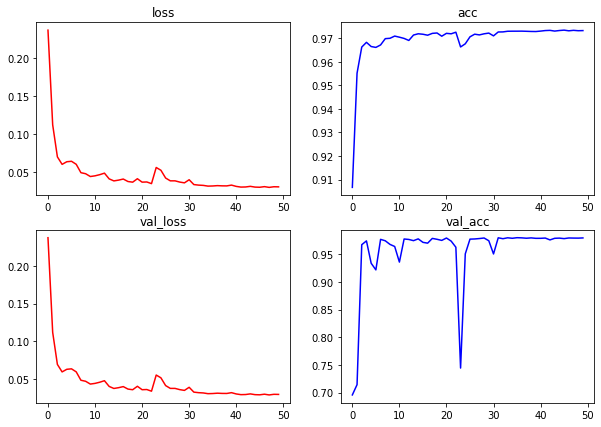

In [14]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].set_title('loss')
ax[0,0].plot(history.history['loss'], 'r')

ax[0,1].set_title('acc')
ax[0,1].plot(history.history['acc'], 'b')

ax[1,0].set_title('val_loss')
ax[1,0].plot(history.history['loss'], 'r')

ax[1,1].set_title('val_acc')
ax[1,1].plot(history.history['val_acc'], 'b')

# Output the resulting image

2/2 [==============================] - 0s 290ms/step


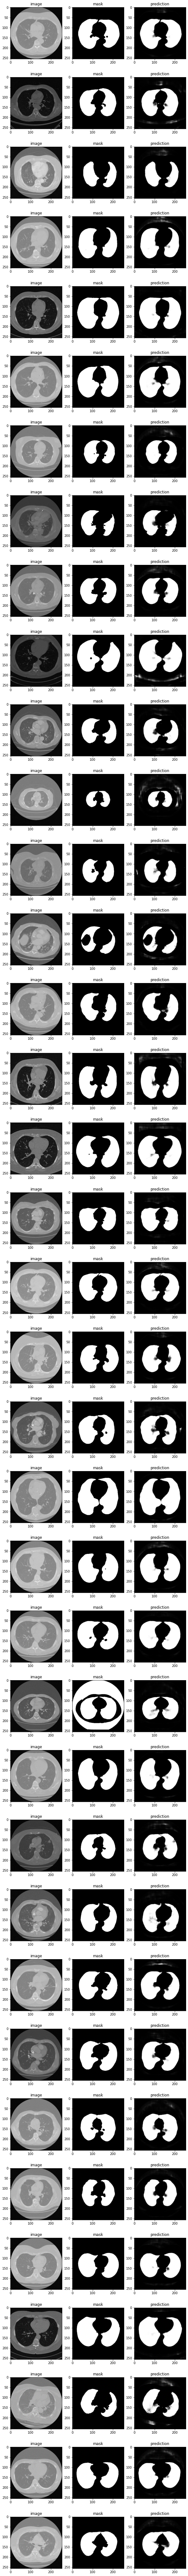

In [17]:
prediction = model.predict(v_imgs)

fix, ax = plt.subplots(len(v_imgs),3,figsize=(10,150))

for i,pred in enumerate(prediction):
  ax[i,0].set_title('image')
  ax[i,0].imshow(v_imgs[i].squeeze(), cmap='gray')
  ax[i,1].set_title('mask')
  ax[i,1].imshow(v_masks[i].squeeze(), cmap='gray')
  ax[i,2].set_title('prediction')
  ax[i,2].imshow(pred.squeeze(), cmap='gray')

# Save Model and Weights

In [20]:
model.save('lung_segmentation_model_2.h5')
model.save_weights('lung_segmentation_weights_2.h5')